# Import Packages

In [1]:
!nvidia-smi

Sat May 28 09:31:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3D:00.0 Off |                    0 |
| N/A   28C    P0    57W / 300W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import glob
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import PIL
from PIL import Image
import json
import torch
import shutil

from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import torch.nn.functional as F

import torch
import numpy as np
import segmentation_models_pytorch as smp
from torch import nn

In [4]:
myseed = 2022
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

# Dataset

In [5]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['bg', 'stas']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        self.masks_fps[i] = self.masks_fps[i].replace('.jpg','.png')
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image.shape != (1024, 512, 3):
            image = cv2.resize(image, (1024, 512), interpolation=cv2.INTER_LANCZOS4)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        if mask.shape != (1024, 512, 3):
            mask = cv2.resize(mask, (1024, 512), interpolation=cv2.INTER_LANCZOS4)  
        mask = mask.astype('bool')
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [6]:
x_Fold1_dir = './Data/SEG_Train_Datasets/Fold1_Images'
y_Fold1_dir = './Data/SEG_Train_Datasets/Fold1_Masks'

x_Fold2_dir = './Data/SEG_Train_Datasets/Fold2_Images'
y_Fold2_dir = './Data/SEG_Train_Datasets/Fold2_Masks'

x_Fold3_dir = './Data/SEG_Train_Datasets/Fold3_Images'
y_Fold3_dir = './Data/SEG_Train_Datasets/Fold3_Masks'

x_Fold4_dir = './Data/SEG_Train_Datasets/Fold4_Images'
y_Fold4_dir = './Data/SEG_Train_Datasets/Fold4_Masks'

x_test_dir = './Data/SEG_Train_Datasets/Test_Images'
y_test_dir = './Data/SEG_Train_Datasets/Test_Masks'

# Data visualization

In [7]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 16))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

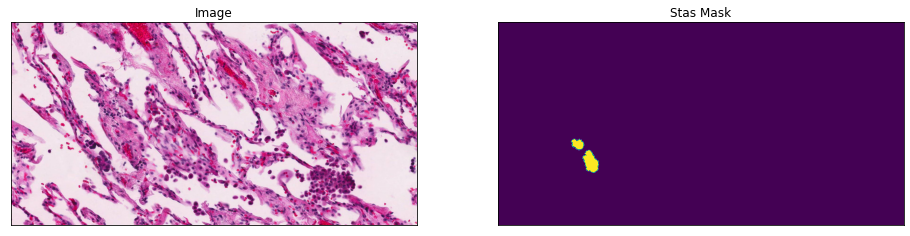

In [8]:
# Lets look at data we have

dataset = Dataset(x_Fold1_dir, y_Fold1_dir, classes=['stas'])

image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    stas_mask=mask.squeeze(),
)

# Augmentation

In [9]:
!pip -q install -U albumentations

In [10]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.Rotate(limit=40,p=1,border_mode=cv2.BORDER_CONSTANT),
        albu.VerticalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        
        albu.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=False, elementwise=False, always_apply=False, p=0.5),
        albu.AdvancedBlur(p=0.5),
        
        albu.Sharpen(p=0.5),
        albu.ColorJitter (brightness=0.3, contrast=0.5, saturation=0.5, hue=0.5, always_apply=False, p=0.6),

        albu.OneOf([
            albu.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
            albu.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            albu.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.5),

        albu.Crop(x_min=0, y_min=0, x_max=1000, y_max=500, p=0.5),
        albu.PadIfNeeded(512, 1024),
    ]
    return albu.Compose(train_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing():
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

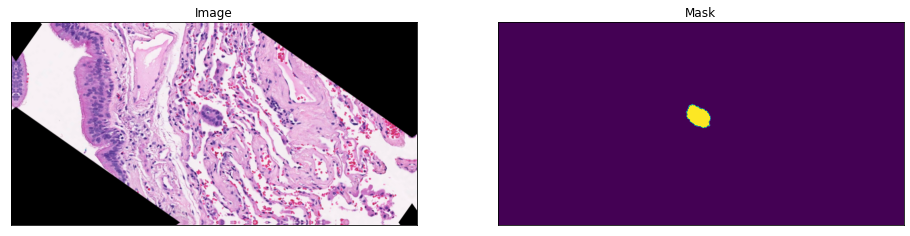

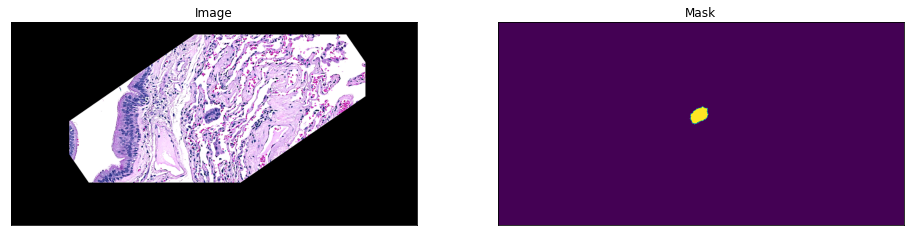

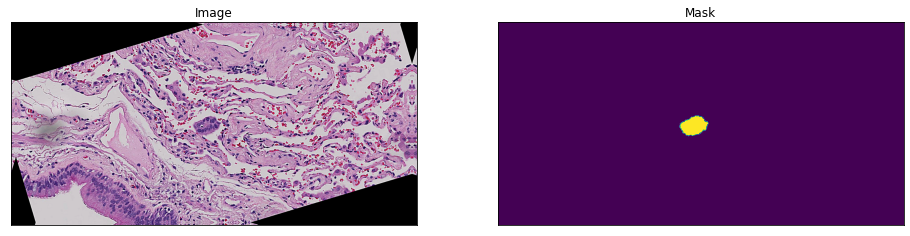

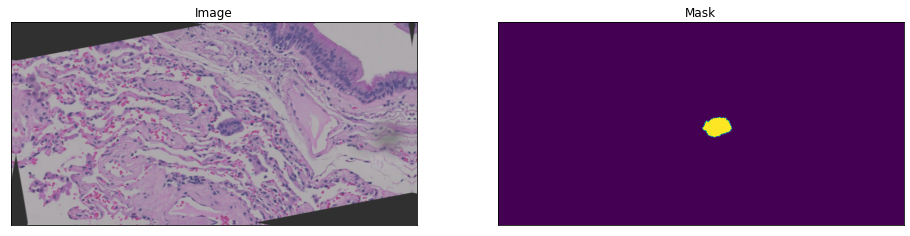

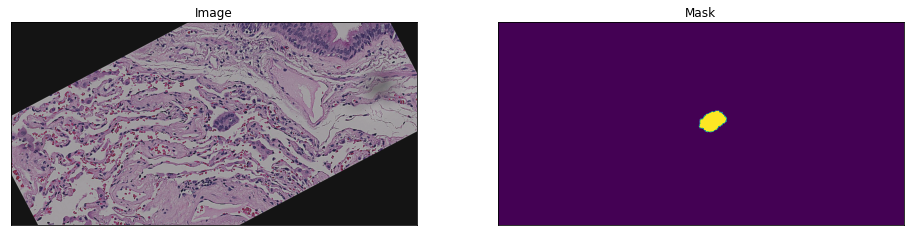

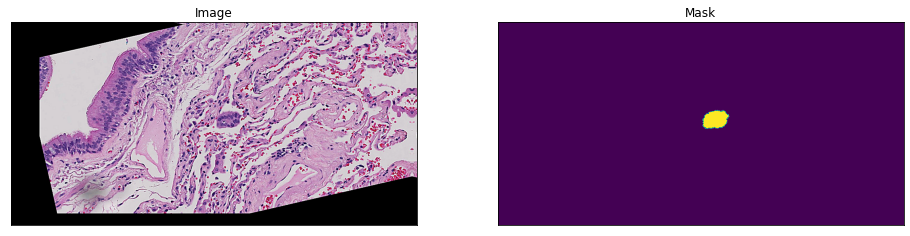

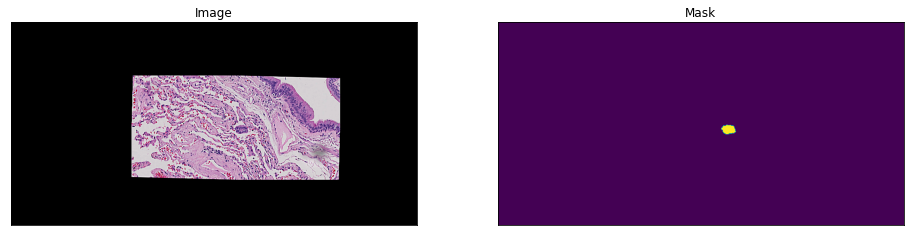

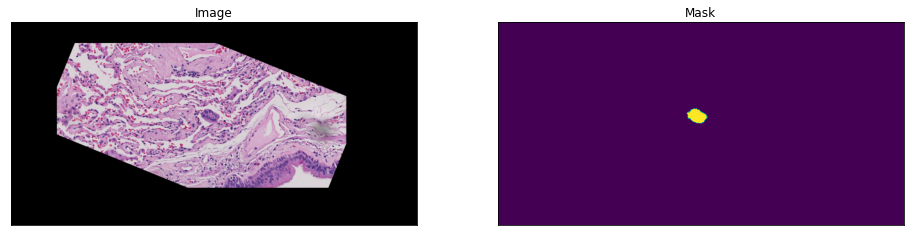

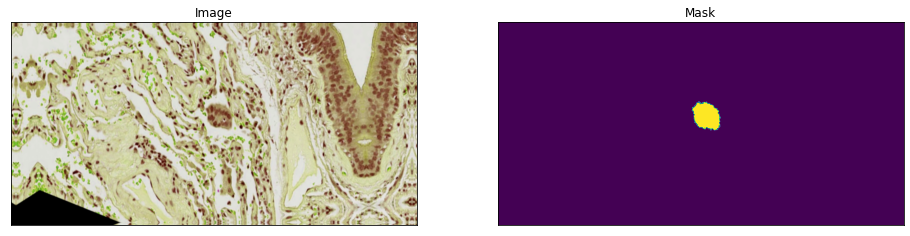

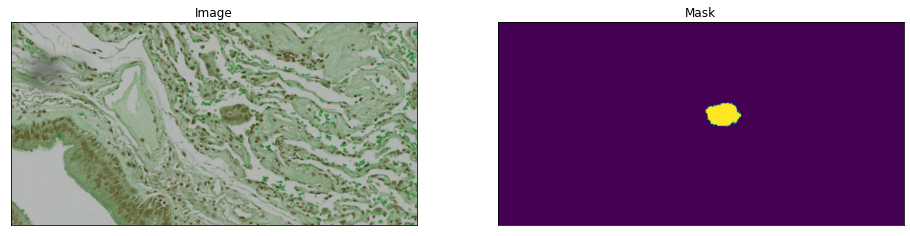

In [11]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_Fold1_dir, 
    y_Fold1_dir, 
    augmentation=get_training_augmentation(), 
    classes=['stas'],
)

# same image with different random transforms
for i in range(10):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))

# DataLoader

In [12]:
from torch.utils.data import ConcatDataset
CLASSES = ['stas']

Fold1_dataset = Dataset(
    x_Fold1_dir, 
    y_Fold1_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(),
    classes=CLASSES,
)

Fold2_dataset = Dataset(
    x_Fold2_dir, 
    y_Fold2_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(),
    classes=CLASSES,
)

Fold3_dataset = Dataset(
    x_Fold3_dir, 
    y_Fold3_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(),
    classes=CLASSES,
)

Fold4_dataset = Dataset(
    x_Fold4_dir, 
    y_Fold4_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(),
    classes=CLASSES,
)

train_dataset_1 = ConcatDataset([Fold1_dataset, Fold2_dataset, Fold3_dataset])
train_dataset_2 = ConcatDataset([Fold1_dataset, Fold2_dataset, Fold4_dataset])
train_dataset_3 = ConcatDataset([Fold1_dataset, Fold3_dataset, Fold4_dataset])
train_dataset_4 = ConcatDataset([Fold2_dataset, Fold3_dataset, Fold4_dataset])

train_loader_1 = DataLoader(train_dataset_1, pin_memory=True, batch_size=4, shuffle=True, num_workers=4)
train_loader_2 = DataLoader(train_dataset_2, pin_memory=True, batch_size=4, shuffle=True, num_workers=4)
train_loader_3 = DataLoader(train_dataset_3, pin_memory=True, batch_size=4, shuffle=True, num_workers=4)
train_loader_4 = DataLoader(train_dataset_4, pin_memory=True, batch_size=4, shuffle=True, num_workers=4)

valid_loader_1 = DataLoader(Fold4_dataset, pin_memory=True, batch_size=4, shuffle=False, num_workers=4)
valid_loader_2 = DataLoader(Fold3_dataset, pin_memory=True, batch_size=4, shuffle=False, num_workers=4)
valid_loader_3 = DataLoader(Fold2_dataset, pin_memory=True, batch_size=4, shuffle=False, num_workers=4)
valid_loader_4 = DataLoader(Fold1_dataset, pin_memory=True, batch_size=4, shuffle=False, num_workers=4)

# Model 1

In [16]:
myseed = 2022
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [17]:
ENCODER = 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['stas']
ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'



# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,

)

In [18]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4),
])

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-7)

In [19]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [20]:
max_score = 0

train_loss_list = []
train_fscore_list = []
valid_loss_list = []
valid_fcore_list = []

for i in range(150):
    
    print('\nEpoch: %d  Learning rate : %.5e'% ((i+1),optimizer.param_groups[0]['lr']))
    train_logs = train_epoch.run(train_loader_1)
    valid_logs = valid_epoch.run(valid_loader_1)
    scheduler.step()

    train_loss_list.append(train_logs['dice_loss'])
    train_fscore_list.append(train_logs['fscore'])
    
    valid_loss_list.append(valid_logs['dice_loss'])
    valid_fcore_list.append(valid_logs['fscore'])
    

    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, './model_weight/best_model_1.pth')
        print('Model saved!')


Epoch: 1  Learning rate : 1.00000e-04
valid: 100%|██████████| 53/53 [00:20<00:00,  2.61it/s, dice_loss - 0.8607, fscore - 0.3281]
Model saved!

Epoch: 2  Learning rate : 9.75553e-05
valid: 100%|██████████| 53/53 [00:21<00:00,  2.51it/s, dice_loss - 0.6953, fscore - 0.5252]
Model saved!

Epoch: 3  Learning rate : 9.04604e-05
valid: 100%|██████████| 53/53 [00:18<00:00,  2.91it/s, dice_loss - 0.4539, fscore - 0.7484]
Model saved!

Epoch: 4  Learning rate : 7.94099e-05
valid: 100%|██████████| 53/53 [00:23<00:00,  2.29it/s, dice_loss - 0.3403, fscore - 0.7973]
Model saved!

Epoch: 5  Learning rate : 6.54854e-05
valid: 100%|██████████| 53/53 [00:20<00:00,  2.58it/s, dice_loss - 0.2971, fscore - 0.797] 

Epoch: 6  Learning rate : 5.00500e-05
valid: 100%|██████████| 53/53 [00:20<00:00,  2.56it/s, dice_loss - 0.2404, fscore - 0.8336]
Model saved!

Epoch: 7  Learning rate : 3.46146e-05
valid: 100%|██████████| 53/53 [00:21<00:00,  2.47it/s, dice_loss - 0.2216, fscore - 0.8437]
Model saved!

Epoc

valid: 100%|██████████| 53/53 [00:21<00:00,  2.50it/s, dice_loss - 0.1362, fscore - 0.8641]

Epoch: 73  Learning rate : 9.98460e-05
valid: 100%|██████████| 53/53 [00:17<00:00,  3.06it/s, dice_loss - 0.1303, fscore - 0.87]  

Epoch: 74  Learning rate : 9.96538e-05
valid: 100%|██████████| 53/53 [00:19<00:00,  2.78it/s, dice_loss - 0.1451, fscore - 0.8551]

Epoch: 75  Learning rate : 9.93850e-05
valid: 100%|██████████| 53/53 [00:20<00:00,  2.56it/s, dice_loss - 0.1803, fscore - 0.82]  

Epoch: 76  Learning rate : 9.90402e-05
valid: 100%|██████████| 53/53 [00:19<00:00,  2.70it/s, dice_loss - 0.144, fscore - 0.8562] 

Epoch: 77  Learning rate : 9.86199e-05
valid: 100%|██████████| 53/53 [00:20<00:00,  2.61it/s, dice_loss - 0.1316, fscore - 0.8686]

Epoch: 78  Learning rate : 9.81246e-05
valid: 100%|██████████| 53/53 [00:22<00:00,  2.39it/s, dice_loss - 0.1654, fscore - 0.8348]

Epoch: 79  Learning rate : 9.75553e-05
valid: 100%|██████████| 53/53 [00:21<00:00,  2.43it/s, dice_loss - 0.1377, f

valid: 100%|██████████| 53/53 [00:22<00:00,  2.41it/s, dice_loss - 0.1178, fscore - 0.8823]

Epoch: 145  Learning rate : 1.48012e-06
valid: 100%|██████████| 53/53 [00:21<00:00,  2.45it/s, dice_loss - 0.1229, fscore - 0.8772]

Epoch: 146  Learning rate : 1.05978e-06
valid: 100%|██████████| 53/53 [00:21<00:00,  2.45it/s, dice_loss - 0.1108, fscore - 0.8893] 
Model saved!

Epoch: 147  Learning rate : 7.14967e-07
valid: 100%|██████████| 53/53 [00:19<00:00,  2.75it/s, dice_loss - 0.1181, fscore - 0.882]  

Epoch: 148  Learning rate : 4.46231e-07
valid: 100%|██████████| 53/53 [00:19<00:00,  2.71it/s, dice_loss - 0.1209, fscore - 0.8792]

Epoch: 149  Learning rate : 2.53979e-07
valid: 100%|██████████| 53/53 [00:21<00:00,  2.45it/s, dice_loss - 0.1166, fscore - 0.8835]

Epoch: 150  Learning rate : 1.38510e-07
valid: 100%|██████████| 53/53 [00:19<00:00,  2.76it/s, dice_loss - 0.1261, fscore - 0.8739]


## Plot

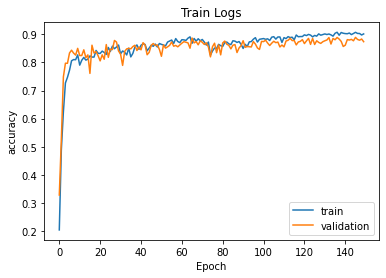

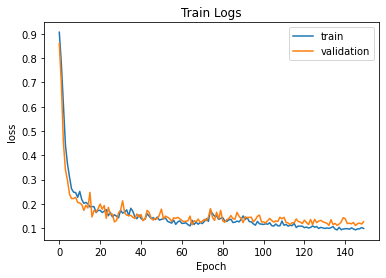

In [22]:
plt.figure(0)
plt.plot(train_fscore_list)
plt.plot(valid_fcore_list)
plt.title('Train Logs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('acc_1.png') 

plt.figure(1)
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('Train Logs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.savefig('loss_1.png') 
plt.show()

## Test

In [23]:
best_model_1 = torch.load('./model_weight/best_model_1.pth')

In [24]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    preprocessing=get_preprocessing(),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [25]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model_1,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 213/213 [00:29<00:00,  7.25it/s, dice_loss - 0.1165, fscore - 0.8836]


In [26]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

00000119.jpg
0


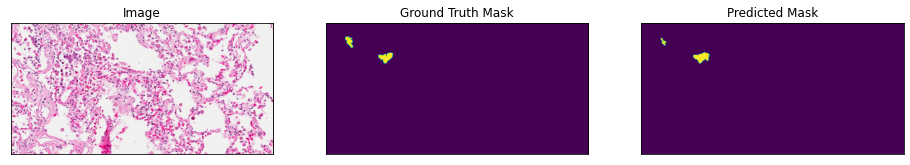

00000919.jpg
1


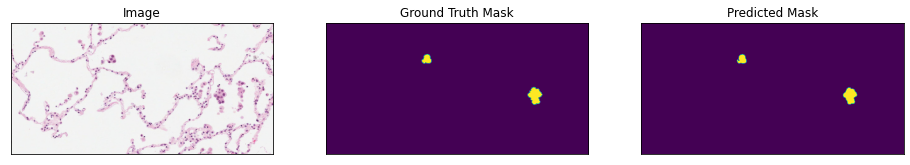

00000784.jpg
2


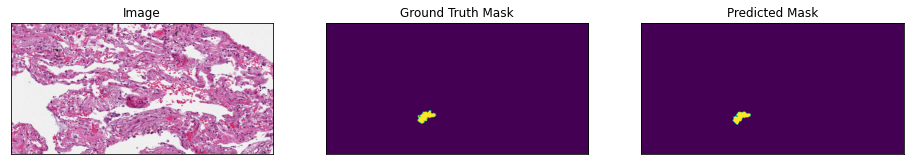

00000369.jpg
3


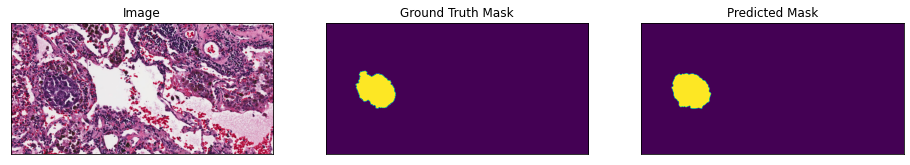

00000224.jpg
4


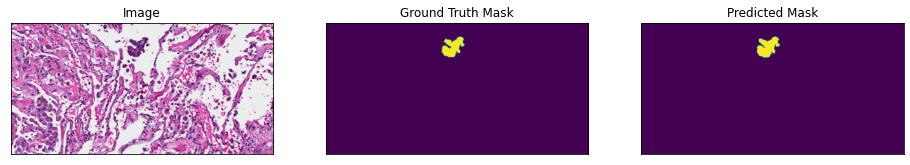

In [27]:
for i in range(len(test_dataset_vis)):
    if i == 5:break
    name = os.path.basename(test_dataset_vis.masks_fps[i])
    print(name)
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model_1.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    zeros = np.zeros((512, 1024))
    zeros[...] = pr_mask * 255
    zeros = cv2.resize(zeros, (1716, 942))
    print(i)
    visualize( 
            image=image_vis, 
            ground_truth_mask=gt_mask.transpose(1, 2, 0)[...,0], 
            predicted_mask=pr_mask
        )

# Model 2

In [30]:
myseed = 2022
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [31]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['stas']
ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'



# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,

)

In [32]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4),
])

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-7)

In [33]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [34]:
max_score = 0

train_loss_list = []
train_fscore_list = []
valid_loss_list = []
valid_fcore_list = []

for i in range(150):
    
    print('\nEpoch: %d  Learning rate : %.5e'% ((i+1),optimizer.param_groups[0]['lr']))
    train_logs = train_epoch.run(train_loader_1)
    valid_logs = valid_epoch.run(valid_loader_1)
    scheduler.step()

    train_loss_list.append(train_logs['dice_loss'])
    train_fscore_list.append(train_logs['fscore'])
    
    valid_loss_list.append(valid_logs['dice_loss'])
    valid_fcore_list.append(valid_logs['fscore'])
    

    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, './model_weight/best_model_2.pth')
        print('Model saved!')


Epoch: 1  Learning rate : 1.00000e-04
valid: 100%|██████████| 53/53 [00:17<00:00,  2.99it/s, dice_loss - 0.8919, fscore - 0.363] 
Model saved!

Epoch: 2  Learning rate : 9.75553e-05
valid: 100%|██████████| 53/53 [00:19<00:00,  2.76it/s, dice_loss - 0.787, fscore - 0.4621] 
Model saved!

Epoch: 3  Learning rate : 9.04604e-05
valid: 100%|██████████| 53/53 [00:14<00:00,  3.55it/s, dice_loss - 0.5777, fscore - 0.6978]
Model saved!

Epoch: 4  Learning rate : 7.94099e-05
valid: 100%|██████████| 53/53 [00:18<00:00,  2.81it/s, dice_loss - 0.3887, fscore - 0.7957]
Model saved!

Epoch: 5  Learning rate : 6.54854e-05
valid: 100%|██████████| 53/53 [00:19<00:00,  2.73it/s, dice_loss - 0.2933, fscore - 0.8094]
Model saved!

Epoch: 6  Learning rate : 5.00500e-05
valid: 100%|██████████| 53/53 [00:19<00:00,  2.71it/s, dice_loss - 0.2501, fscore - 0.8276]
Model saved!

Epoch: 7  Learning rate : 3.46146e-05
valid: 100%|██████████| 53/53 [00:18<00:00,  2.85it/s, dice_loss - 0.2534, fscore - 0.8049]

Epoc

valid: 100%|██████████| 53/53 [00:18<00:00,  2.91it/s, dice_loss - 0.1423, fscore - 0.8579]

Epoch: 73  Learning rate : 9.98460e-05
valid: 100%|██████████| 53/53 [00:16<00:00,  3.20it/s, dice_loss - 0.1691, fscore - 0.8313]

Epoch: 74  Learning rate : 9.96538e-05
valid: 100%|██████████| 53/53 [00:20<00:00,  2.54it/s, dice_loss - 0.1342, fscore - 0.866] 

Epoch: 75  Learning rate : 9.93850e-05
valid: 100%|██████████| 53/53 [00:17<00:00,  3.02it/s, dice_loss - 0.1488, fscore - 0.8514]

Epoch: 76  Learning rate : 9.90402e-05
valid: 100%|██████████| 53/53 [00:22<00:00,  2.38it/s, dice_loss - 0.1625, fscore - 0.8378]

Epoch: 77  Learning rate : 9.86199e-05
valid: 100%|██████████| 53/53 [00:16<00:00,  3.15it/s, dice_loss - 0.1374, fscore - 0.8628]

Epoch: 78  Learning rate : 9.81246e-05
valid: 100%|██████████| 53/53 [00:16<00:00,  3.29it/s, dice_loss - 0.1485, fscore - 0.8517]

Epoch: 79  Learning rate : 9.75553e-05
valid: 100%|██████████| 53/53 [00:17<00:00,  3.02it/s, dice_loss - 0.1542, f

valid: 100%|██████████| 53/53 [00:20<00:00,  2.58it/s, dice_loss - 0.1167, fscore - 0.8834]

Epoch: 145  Learning rate : 1.48012e-06
valid: 100%|██████████| 53/53 [00:20<00:00,  2.53it/s, dice_loss - 0.1231, fscore - 0.877] 

Epoch: 146  Learning rate : 1.05978e-06
valid: 100%|██████████| 53/53 [00:18<00:00,  2.94it/s, dice_loss - 0.1132, fscore - 0.887]  

Epoch: 147  Learning rate : 7.14967e-07
valid: 100%|██████████| 53/53 [00:22<00:00,  2.40it/s, dice_loss - 0.1241, fscore - 0.876] 

Epoch: 148  Learning rate : 4.46231e-07
valid: 100%|██████████| 53/53 [00:19<00:00,  2.73it/s, dice_loss - 0.1176, fscore - 0.8825]

Epoch: 149  Learning rate : 2.53979e-07
valid: 100%|██████████| 53/53 [00:21<00:00,  2.46it/s, dice_loss - 0.1161, fscore - 0.8841]

Epoch: 150  Learning rate : 1.38510e-07
valid: 100%|██████████| 53/53 [00:17<00:00,  3.03it/s, dice_loss - 0.1165, fscore - 0.8836]


## Plot

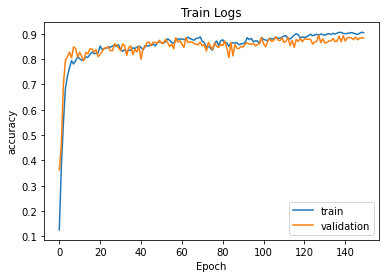

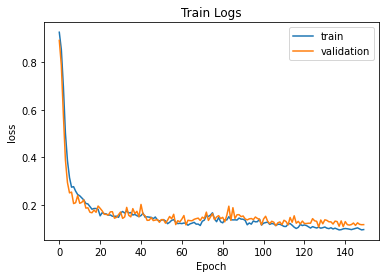

In [35]:
plt.figure(0)
plt.plot(train_fscore_list)
plt.plot(valid_fcore_list)
plt.title('Train Logs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('acc_2.png') 

plt.figure(1)
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('Train Logs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.savefig('loss_2.png') 
plt.show()

## Test

In [36]:
best_model_2 = torch.load('./model_weight/best_model_2.pth')

In [37]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    preprocessing=get_preprocessing(),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [38]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model_2,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 213/213 [00:24<00:00,  8.84it/s, dice_loss - 0.1291, fscore - 0.871] 


In [39]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

00000119.jpg
0


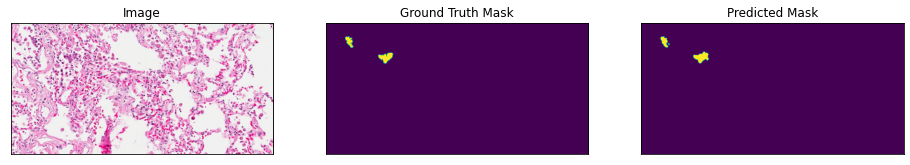

00000919.jpg
1


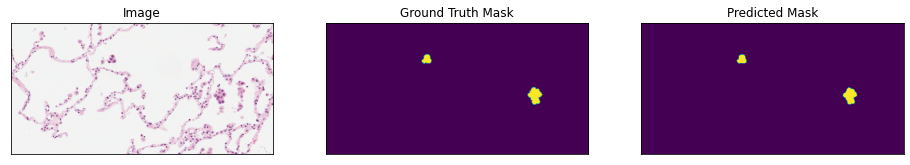

00000784.jpg
2


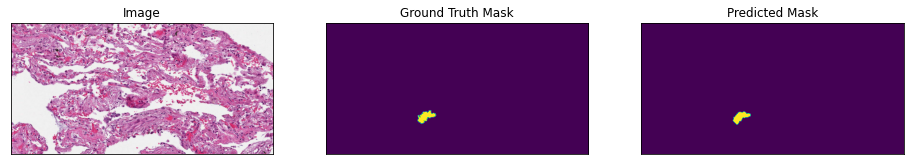

00000369.jpg
3


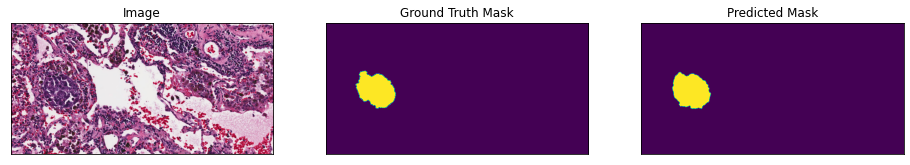

00000224.jpg
4


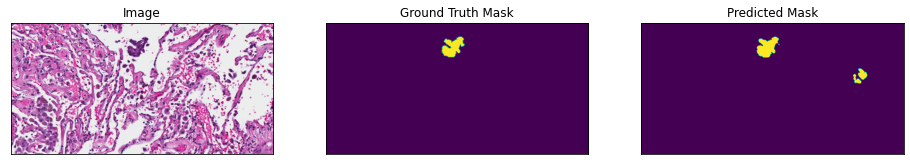

In [40]:
for i in range(len(test_dataset_vis)):
    if i == 5:break
    name = os.path.basename(test_dataset_vis.masks_fps[i])
    print(name)
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model_2.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    #len(pr_mask)
    #print(gt_mask.shape)
    zeros = np.zeros((512, 1024))
    zeros[...] = pr_mask * 255
    zeros = cv2.resize(zeros, (1716, 942))
    print(i)
    visualize( 
            image=image_vis, 
            ground_truth_mask=gt_mask.transpose(1, 2, 0)[...,0], 
            predicted_mask=pr_mask
        )

# Model 3

In [41]:
myseed = 2022
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [42]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['stas']
ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'



# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,

)

In [43]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4),
])

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-7)

In [44]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [45]:
max_score = 0

train_loss_list = []
train_fscore_list = []
valid_loss_list = []
valid_fcore_list = []

for i in range(150):
    
    print('\nEpoch: %d  Learning rate : %.5e'% ((i+1),optimizer.param_groups[0]['lr']))
    train_logs = train_epoch.run(train_loader_2)
    valid_logs = valid_epoch.run(valid_loader_2)
    scheduler.step()

    train_loss_list.append(train_logs['dice_loss'])
    train_fscore_list.append(train_logs['fscore'])
    
    valid_loss_list.append(valid_logs['dice_loss'])
    valid_fcore_list.append(valid_logs['fscore'])
    

    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, './model_weight/best_model_3.pth')
        print('Model saved!')


Epoch: 1  Learning rate : 1.00000e-04
valid: 100%|██████████| 53/53 [01:21<00:00,  1.53s/it, dice_loss - 0.8256, fscore - 0.3166]
Model saved!

Epoch: 2  Learning rate : 9.75553e-05
valid: 100%|██████████| 53/53 [01:22<00:00,  1.55s/it, dice_loss - 0.5662, fscore - 0.6291]
Model saved!

Epoch: 3  Learning rate : 9.04604e-05
valid: 100%|██████████| 53/53 [01:21<00:00,  1.54s/it, dice_loss - 0.3714, fscore - 0.7009]
Model saved!

Epoch: 4  Learning rate : 7.94099e-05
valid: 100%|██████████| 53/53 [01:21<00:00,  1.54s/it, dice_loss - 0.3197, fscore - 0.7203]
Model saved!

Epoch: 5  Learning rate : 6.54854e-05
valid: 100%|██████████| 53/53 [01:22<00:00,  1.56s/it, dice_loss - 0.2768, fscore - 0.7557]
Model saved!

Epoch: 6  Learning rate : 5.00500e-05
valid: 100%|██████████| 53/53 [01:21<00:00,  1.54s/it, dice_loss - 0.2894, fscore - 0.7343]

Epoch: 7  Learning rate : 3.46146e-05
valid: 100%|██████████| 53/53 [01:22<00:00,  1.55s/it, dice_loss - 0.2484, fscore - 0.7743]
Model saved!

Epoc

valid: 100%|██████████| 53/53 [01:25<00:00,  1.62s/it, dice_loss - 0.1551, fscore - 0.8466]

Epoch: 73  Learning rate : 9.98460e-05
valid: 100%|██████████| 53/53 [01:24<00:00,  1.59s/it, dice_loss - 0.1796, fscore - 0.8217]

Epoch: 74  Learning rate : 9.96538e-05
valid: 100%|██████████| 53/53 [01:24<00:00,  1.60s/it, dice_loss - 0.1515, fscore - 0.8506]

Epoch: 75  Learning rate : 9.93850e-05
valid: 100%|██████████| 53/53 [01:24<00:00,  1.60s/it, dice_loss - 0.1528, fscore - 0.8489]

Epoch: 76  Learning rate : 9.90402e-05
valid: 100%|██████████| 53/53 [01:26<00:00,  1.63s/it, dice_loss - 0.1811, fscore - 0.8208]

Epoch: 77  Learning rate : 9.86199e-05
valid: 100%|██████████| 53/53 [01:24<00:00,  1.59s/it, dice_loss - 0.1643, fscore - 0.8374]

Epoch: 78  Learning rate : 9.81246e-05
valid: 100%|██████████| 53/53 [01:24<00:00,  1.59s/it, dice_loss - 0.174, fscore - 0.8275] 

Epoch: 79  Learning rate : 9.75553e-05
valid: 100%|██████████| 53/53 [01:24<00:00,  1.60s/it, dice_loss - 0.1667, f

valid: 100%|██████████| 53/53 [01:21<00:00,  1.54s/it, dice_loss - 0.1632, fscore - 0.8376]

Epoch: 145  Learning rate : 1.48012e-06
valid: 100%|██████████| 53/53 [01:21<00:00,  1.53s/it, dice_loss - 0.1309, fscore - 0.8703]

Epoch: 146  Learning rate : 1.05978e-06
valid: 100%|██████████| 53/53 [01:22<00:00,  1.56s/it, dice_loss - 0.1332, fscore - 0.8677]

Epoch: 147  Learning rate : 7.14967e-07
valid: 100%|██████████| 53/53 [01:22<00:00,  1.55s/it, dice_loss - 0.1335, fscore - 0.8673]

Epoch: 148  Learning rate : 4.46231e-07
valid: 100%|██████████| 53/53 [01:22<00:00,  1.56s/it, dice_loss - 0.127, fscore - 0.874]  

Epoch: 149  Learning rate : 2.53979e-07
valid: 100%|██████████| 53/53 [01:21<00:00,  1.54s/it, dice_loss - 0.122, fscore - 0.8792] 

Epoch: 150  Learning rate : 1.38510e-07
valid: 100%|██████████| 53/53 [01:22<00:00,  1.57s/it, dice_loss - 0.1352, fscore - 0.8656]


## Plot

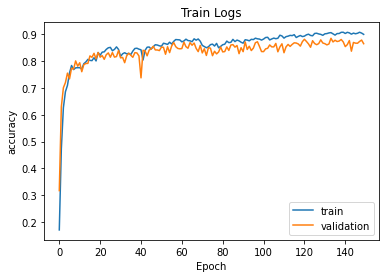

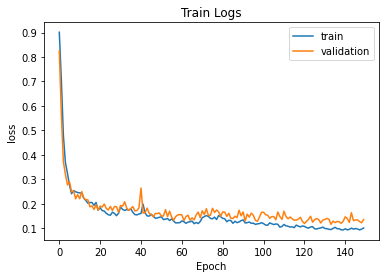

In [46]:
plt.figure(0)
plt.plot(train_fscore_list)
plt.plot(valid_fcore_list)
plt.title('Train Logs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('acc_3.png') 

plt.figure(1)
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('Train Logs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.savefig('loss_3.png') 
plt.show()

## Test

In [47]:
best_model_3 = torch.load('./model_weight/best_model_3.pth')

In [48]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    preprocessing=get_preprocessing(),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [49]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model_3,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 213/213 [01:36<00:00,  2.21it/s, dice_loss - 0.1225, fscore - 0.8785]


In [50]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

00000119.jpg
0


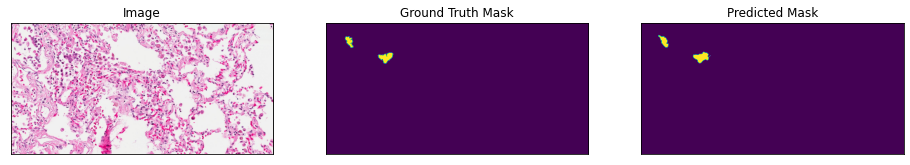

00000919.jpg
1


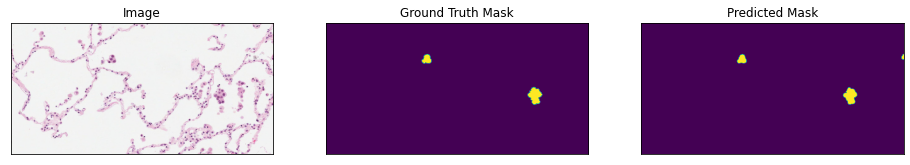

00000784.jpg
2


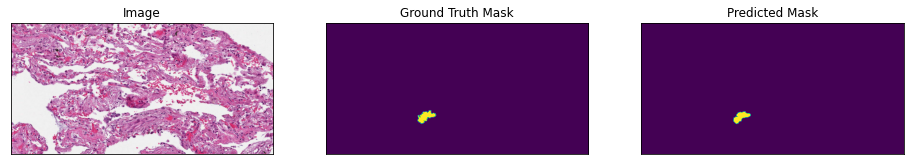

00000369.jpg
3


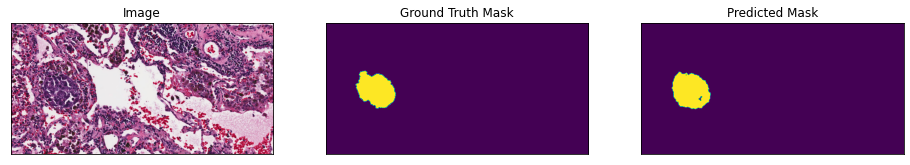

00000224.jpg
4


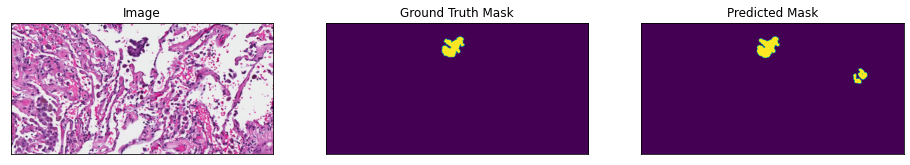

In [51]:
for i in range(len(test_dataset_vis)):
    if i == 5:break
    name = os.path.basename(test_dataset_vis.masks_fps[i])
    print(name)
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model_3.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    #len(pr_mask)
    #print(gt_mask.shape)
    zeros = np.zeros((512, 1024))
    zeros[...] = pr_mask * 255
    zeros = cv2.resize(zeros, (1716, 942))
    print(i)
    visualize( 
            image=image_vis, 
            ground_truth_mask=gt_mask.transpose(1, 2, 0)[...,0], 
            predicted_mask=pr_mask
        )

# Model 4

In [70]:
myseed = 2022
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [71]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['stas']
ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'



# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,

)

In [72]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4),
])

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-7)

In [73]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [74]:
max_score = 0

train_loss_list = []
train_fscore_list = []
valid_loss_list = []
valid_fcore_list = []

for i in range(150):
    
    print('\nEpoch: %d  Learning rate : %.5e'% ((i+1),optimizer.param_groups[0]['lr']))
    train_logs = train_epoch.run(train_loader_3)
    valid_logs = valid_epoch.run(valid_loader_3)
    scheduler.step()

    train_loss_list.append(train_logs['dice_loss'])
    train_fscore_list.append(train_logs['fscore'])
    
    valid_loss_list.append(valid_logs['dice_loss'])
    valid_fcore_list.append(valid_logs['fscore'])
    

    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, './model_weight/best_model_4.pth')
        print('Model saved!')


Epoch: 1  Learning rate : 1.00000e-04
valid: 100%|██████████| 53/53 [00:22<00:00,  2.40it/s, dice_loss - 0.7562, fscore - 0.444] 
Model saved!

Epoch: 2  Learning rate : 9.75553e-05
valid: 100%|██████████| 53/53 [00:20<00:00,  2.57it/s, dice_loss - 0.4973, fscore - 0.6916]
Model saved!

Epoch: 3  Learning rate : 9.04604e-05
valid: 100%|██████████| 53/53 [00:21<00:00,  2.52it/s, dice_loss - 0.4027, fscore - 0.7176]
Model saved!

Epoch: 4  Learning rate : 7.94099e-05
valid: 100%|██████████| 53/53 [00:21<00:00,  2.44it/s, dice_loss - 0.3253, fscore - 0.7316]
Model saved!

Epoch: 5  Learning rate : 6.54854e-05
valid: 100%|██████████| 53/53 [00:23<00:00,  2.26it/s, dice_loss - 0.331, fscore - 0.709]  

Epoch: 6  Learning rate : 5.00500e-05
valid: 100%|██████████| 53/53 [00:21<00:00,  2.47it/s, dice_loss - 0.2578, fscore - 0.7756]
Model saved!

Epoch: 7  Learning rate : 3.46146e-05
valid: 100%|██████████| 53/53 [00:23<00:00,  2.22it/s, dice_loss - 0.2664, fscore - 0.7653]

Epoch: 8  Learnin

valid: 100%|██████████| 53/53 [00:21<00:00,  2.42it/s, dice_loss - 0.2502, fscore - 0.7501]

Epoch: 73  Learning rate : 9.98460e-05
valid: 100%|██████████| 53/53 [00:23<00:00,  2.28it/s, dice_loss - 0.2484, fscore - 0.7518]

Epoch: 74  Learning rate : 9.96538e-05
valid: 100%|██████████| 53/53 [00:19<00:00,  2.65it/s, dice_loss - 0.2276, fscore - 0.7727]

Epoch: 75  Learning rate : 9.93850e-05
valid: 100%|██████████| 53/53 [00:22<00:00,  2.39it/s, dice_loss - 0.2466, fscore - 0.7537]

Epoch: 76  Learning rate : 9.90402e-05
valid: 100%|██████████| 53/53 [00:22<00:00,  2.31it/s, dice_loss - 0.2159, fscore - 0.7843]

Epoch: 77  Learning rate : 9.86199e-05
valid: 100%|██████████| 53/53 [00:21<00:00,  2.52it/s, dice_loss - 0.2494, fscore - 0.7508]

Epoch: 78  Learning rate : 9.81246e-05
valid: 100%|██████████| 53/53 [00:23<00:00,  2.29it/s, dice_loss - 0.2475, fscore - 0.7527]

Epoch: 79  Learning rate : 9.75553e-05
valid: 100%|██████████| 53/53 [00:23<00:00,  2.23it/s, dice_loss - 0.206, fs

valid: 100%|██████████| 53/53 [00:22<00:00,  2.33it/s, dice_loss - 0.1521, fscore - 0.8481]

Epoch: 145  Learning rate : 1.48012e-06
valid: 100%|██████████| 53/53 [00:22<00:00,  2.37it/s, dice_loss - 0.1613, fscore - 0.8387]

Epoch: 146  Learning rate : 1.05978e-06
valid: 100%|██████████| 53/53 [00:23<00:00,  2.30it/s, dice_loss - 0.1452, fscore - 0.8549]

Epoch: 147  Learning rate : 7.14967e-07
valid: 100%|██████████| 53/53 [00:19<00:00,  2.73it/s, dice_loss - 0.1642, fscore - 0.8359]

Epoch: 148  Learning rate : 4.46231e-07
valid: 100%|██████████| 53/53 [00:20<00:00,  2.53it/s, dice_loss - 0.1815, fscore - 0.8186]

Epoch: 149  Learning rate : 2.53979e-07
valid: 100%|██████████| 53/53 [00:22<00:00,  2.35it/s, dice_loss - 0.16, fscore - 0.8401]  

Epoch: 150  Learning rate : 1.38510e-07
valid: 100%|██████████| 53/53 [00:20<00:00,  2.63it/s, dice_loss - 0.1425, fscore - 0.8576]


## Plot

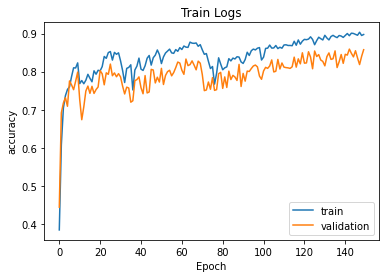

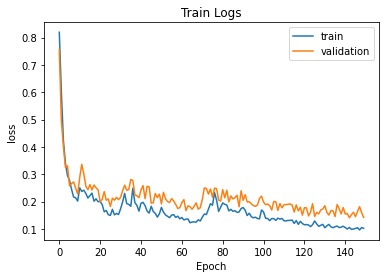

In [75]:
plt.figure(0)
plt.plot(train_fscore_list)
plt.plot(valid_fcore_list)
plt.title('Train Logs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('./fig/acc_4.png') 

plt.figure(1)
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('Train Logs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.savefig('./fig/loss_4.png') 
plt.show()

## Test

In [76]:
best_model_4 = torch.load('./model_weight/best_model_4.pth')

In [77]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    preprocessing=get_preprocessing(),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [78]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 213/213 [00:31<00:00,  6.76it/s, dice_loss - 0.1266, fscore - 0.8735]


In [79]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

00000119.jpg
0


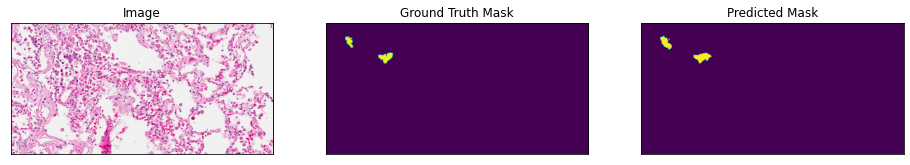

00000919.jpg
1


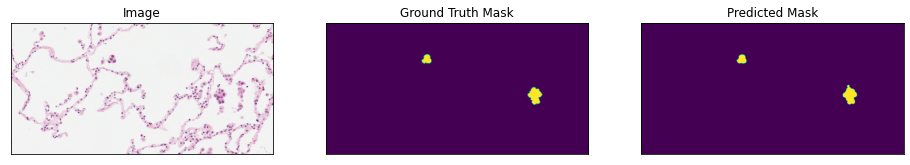

00000784.jpg
2


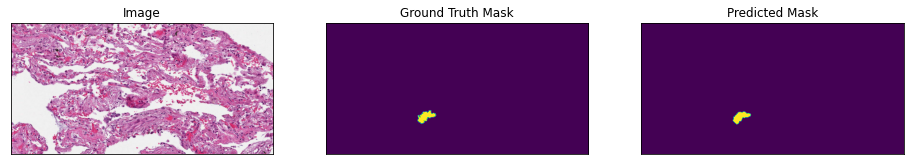

00000369.jpg
3


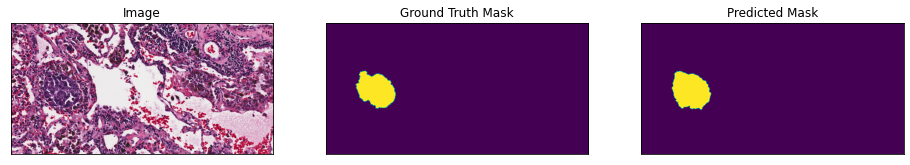

00000224.jpg
4


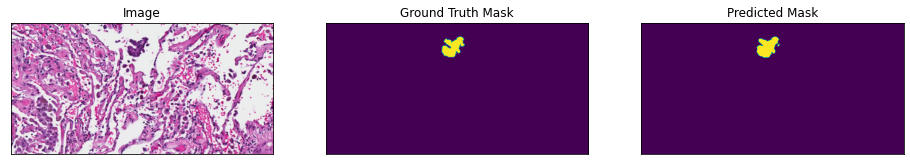

In [80]:
for i in range(len(test_dataset_vis)):
    if i == 5:break
    name = os.path.basename(test_dataset_vis.masks_fps[i])
    print(name)
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model_4.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    #len(pr_mask)
    #print(gt_mask.shape)
    zeros = np.zeros((512, 1024))
    zeros[...] = pr_mask * 255
    zeros = cv2.resize(zeros, (1716, 942))
    print(i)
    visualize( 
            image=image_vis, 
            ground_truth_mask=gt_mask.transpose(1, 2, 0)[...,0], 
            predicted_mask=pr_mask
        )

# Model 5

In [81]:
myseed = 2022
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [82]:
ENCODER = 'efficientnet-b5'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['stas']
ACTIVATION = 'sigmoid' 
DEVICE = 'cuda'



# create segmentation model with pretrained encoder
model = smp.Linknet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,

)

In [83]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.Fscore(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=1e-4),
])

scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-7)

In [84]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [85]:
max_score = 0

train_loss_list = []
train_fscore_list = []
valid_loss_list = []
valid_fcore_list = []

for i in range(150):
    
    print('\nEpoch: %d  Learning rate : %.5e'% ((i+1),optimizer.param_groups[0]['lr']))
    train_logs = train_epoch.run(train_loader_4)
    valid_logs = valid_epoch.run(valid_loader_4)
    scheduler.step()

    train_loss_list.append(train_logs['dice_loss'])
    train_fscore_list.append(train_logs['fscore'])
    
    valid_loss_list.append(valid_logs['dice_loss'])
    valid_fcore_list.append(valid_logs['fscore'])
    

    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, './model_weight/best_model_5.pth')
        print('Model saved!')


Epoch: 1  Learning rate : 1.00000e-04
valid: 100%|██████████| 53/53 [00:18<00:00,  2.82it/s, dice_loss - 0.9453, fscore - 0.07957]
Model saved!

Epoch: 2  Learning rate : 9.75553e-05
valid: 100%|██████████| 53/53 [00:16<00:00,  3.29it/s, dice_loss - 0.9359, fscore - 0.08366]
Model saved!

Epoch: 3  Learning rate : 9.04604e-05
valid: 100%|██████████| 53/53 [00:22<00:00,  2.36it/s, dice_loss - 0.9131, fscore - 0.111]  
Model saved!

Epoch: 4  Learning rate : 7.94099e-05
valid: 100%|██████████| 53/53 [00:19<00:00,  2.69it/s, dice_loss - 0.8716, fscore - 0.2959]
Model saved!

Epoch: 5  Learning rate : 6.54854e-05
valid: 100%|██████████| 53/53 [00:16<00:00,  3.27it/s, dice_loss - 0.8265, fscore - 0.5412]
Model saved!

Epoch: 6  Learning rate : 5.00500e-05
valid: 100%|██████████| 53/53 [00:14<00:00,  3.58it/s, dice_loss - 0.7844, fscore - 0.6575]
Model saved!

Epoch: 7  Learning rate : 3.46146e-05
valid: 100%|██████████| 53/53 [00:20<00:00,  2.58it/s, dice_loss - 0.7438, fscore - 0.6903]
Mo

valid: 100%|██████████| 53/53 [00:20<00:00,  2.62it/s, dice_loss - 0.1985, fscore - 0.8033]

Epoch: 73  Learning rate : 9.98460e-05
valid: 100%|██████████| 53/53 [00:18<00:00,  2.89it/s, dice_loss - 0.1767, fscore - 0.8249]

Epoch: 74  Learning rate : 9.96538e-05
valid: 100%|██████████| 53/53 [00:14<00:00,  3.70it/s, dice_loss - 0.1467, fscore - 0.8547]

Epoch: 75  Learning rate : 9.93850e-05
valid: 100%|██████████| 53/53 [00:22<00:00,  2.38it/s, dice_loss - 0.1413, fscore - 0.8602]

Epoch: 76  Learning rate : 9.90402e-05
valid: 100%|██████████| 53/53 [00:18<00:00,  2.81it/s, dice_loss - 0.1703, fscore - 0.831] 

Epoch: 77  Learning rate : 9.86199e-05
valid: 100%|██████████| 53/53 [00:20<00:00,  2.58it/s, dice_loss - 0.1859, fscore - 0.8153]

Epoch: 78  Learning rate : 9.81246e-05
valid: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s, dice_loss - 0.1697, fscore - 0.8315]

Epoch: 79  Learning rate : 9.75553e-05
valid: 100%|██████████| 53/53 [00:16<00:00,  3.30it/s, dice_loss - 0.1924, f

valid: 100%|██████████| 53/53 [00:18<00:00,  2.88it/s, dice_loss - 0.1256, fscore - 0.8748]

Epoch: 145  Learning rate : 1.48012e-06
valid: 100%|██████████| 53/53 [00:19<00:00,  2.65it/s, dice_loss - 0.1289, fscore - 0.8714] 

Epoch: 146  Learning rate : 1.05978e-06
valid: 100%|██████████| 53/53 [00:18<00:00,  2.84it/s, dice_loss - 0.1253, fscore - 0.875] 

Epoch: 147  Learning rate : 7.14967e-07
valid: 100%|██████████| 53/53 [00:16<00:00,  3.18it/s, dice_loss - 0.1159, fscore - 0.8844] 
Model saved!

Epoch: 148  Learning rate : 4.46231e-07
valid: 100%|██████████| 53/53 [00:16<00:00,  3.12it/s, dice_loss - 0.1283, fscore - 0.8721]

Epoch: 149  Learning rate : 2.53979e-07
valid: 100%|██████████| 53/53 [00:19<00:00,  2.73it/s, dice_loss - 0.1376, fscore - 0.8628] 

Epoch: 150  Learning rate : 1.38510e-07
valid: 100%|██████████| 53/53 [00:16<00:00,  3.27it/s, dice_loss - 0.1226, fscore - 0.8777]


## Plot

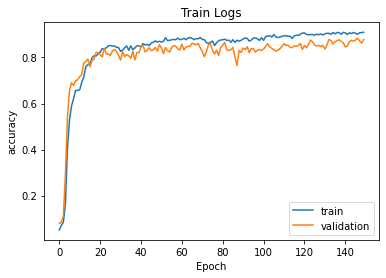

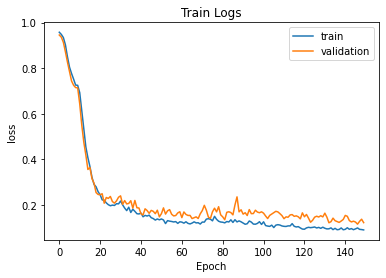

In [86]:
plt.figure(0)
plt.plot(train_fscore_list)
plt.plot(valid_fcore_list)
plt.title('Train Logs')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.savefig('./fig/acc_5.png') 

plt.figure(1)
plt.plot(train_loss_list)
plt.plot(valid_loss_list)
plt.title('Train Logs')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')

plt.savefig('./fig/loss_5.png') 
plt.show()

## Test

In [87]:
best_model_5 = torch.load('./model_weight/best_model_5.pth')

In [88]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    preprocessing=get_preprocessing(),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [89]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model_5,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 213/213 [00:16<00:00, 13.29it/s, dice_loss - 0.1124, fscore - 0.8879]


In [90]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

00000119.jpg
0


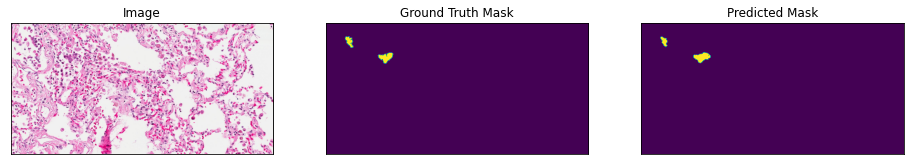

00000919.jpg
1


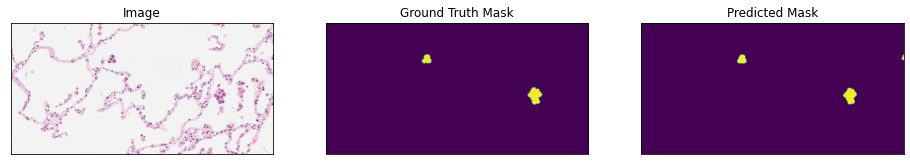

00000784.jpg
2


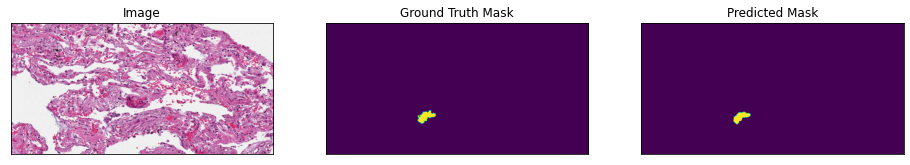

00000369.jpg
3


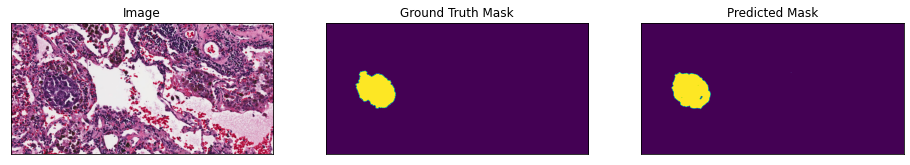

00000224.jpg
4


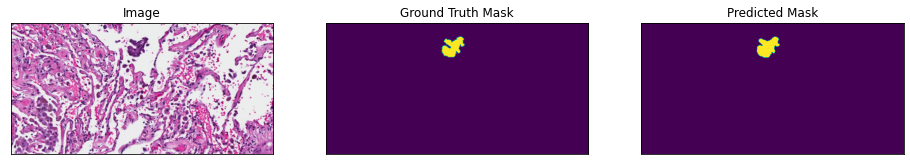

In [91]:
for i in range(len(test_dataset_vis)):
    if i == 5:break
    name = os.path.basename(test_dataset_vis.masks_fps[i])
    print(name)
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model_5.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    #len(pr_mask)
    #print(gt_mask.shape)
    zeros = np.zeros((512, 1024))
    zeros[...] = pr_mask * 255
    zeros = cv2.resize(zeros, (1716, 942))
    print(i)
    visualize( 
            image=image_vis, 
            ground_truth_mask=gt_mask.transpose(1, 2, 0)[...,0], 
            predicted_mask=pr_mask
        )